### Abstract


This project applied AutoML to forecast bike rental counts, leveraging H2O's AutoML to evaluate various models, excluding ensemble methods for simplicity and interpretability. SHAP and LIME analyses were utilized to understand feature impacts on predictions, revealing key influences like year and temperature. The comparative interpretability across models provided nuanced insights into predictive factors, with the AutoML approach effectively balancing model complexity and predictive power.

# Buisness question
How can we accurately predict daily bike rental counts based on environmental factors and seasonal settings, and how might these counts be influenced by specific events or anomalies?

This question encompasses several key components:

1. Prediction: Utilizing historical data to forecast future bike rental demand.
2. Influencing Factors: Understanding how various factors such as weather conditions (e.g., temperature, humidity, windspeed), seasonality (e.g., time of year, month, holiday status), and temporal aspects (e.g., day of the week) correlate with rental frequency.
3. `Event Detection: Identifying whether there are outliers or patterns in the data that could correspond to specific events or anomalies, like public holidays, special events in the city, or extreme weather conditions.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
! apt-get install default-jre
! java -version
! pip install h2o
!pip install shap


# Load the dataset
!git clone https://github.com/surya-madhav/BokeSharingDataScience.git
daily_data_path = './BokeSharingDataScience/day.csv'
df = h2o.import_file(daily_data_path)
daily_data_path, df.shape
df.describe()

# Display the first few rows of the dataset
print(df.head())

# Understand the structure of the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())


   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
<class 'pandas.core.frame.

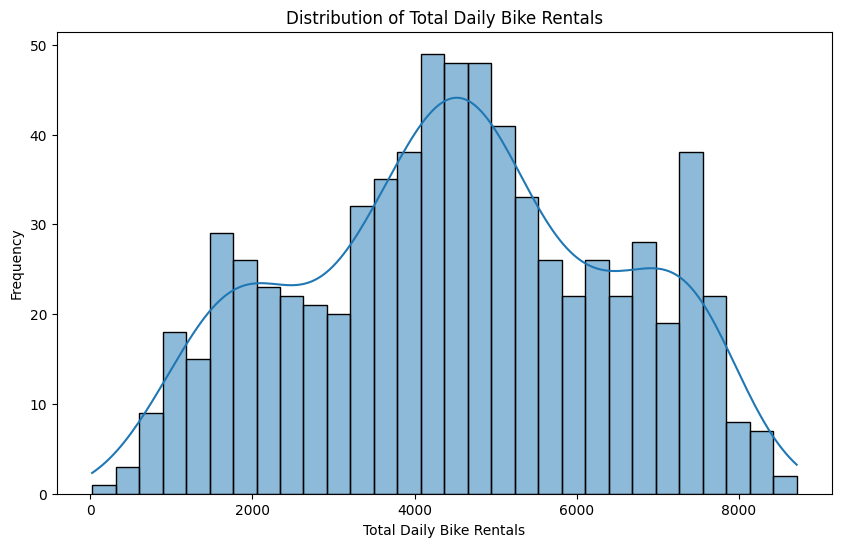

In [ ]:
# Distribution of total daily bike rentals
plt.figure(figsize=(10, 6))
sns.histplot(df['cnt'], kde=True, bins=30)
plt.title('Distribution of Total Daily Bike Rentals')
plt.xlabel('Total Daily Bike Rentals')
plt.ylabel('Frequency')
plt.show()


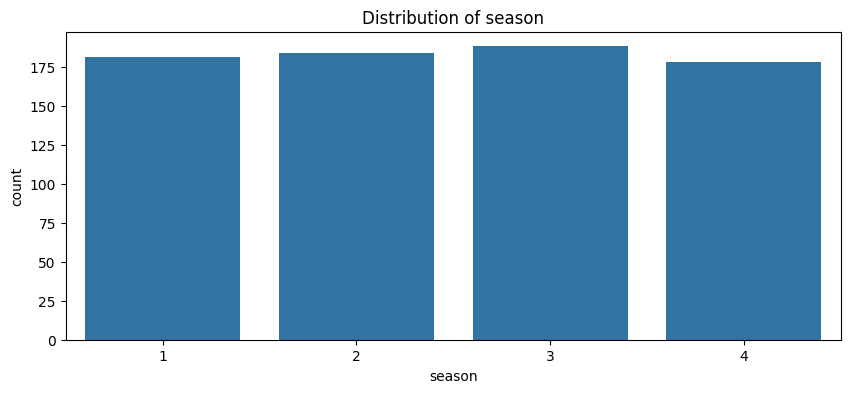

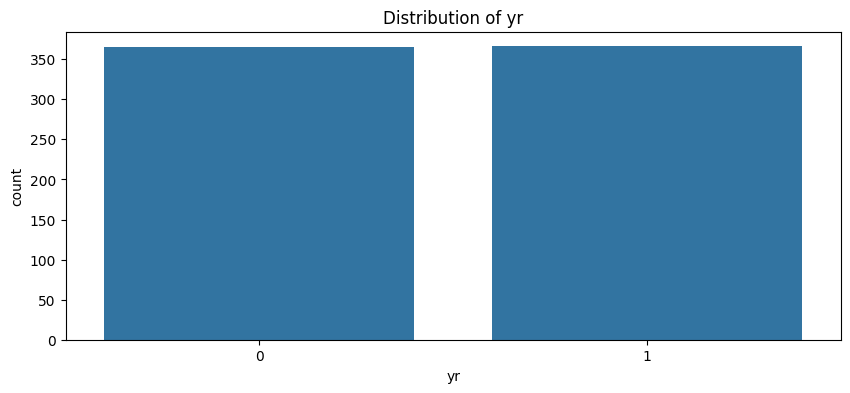

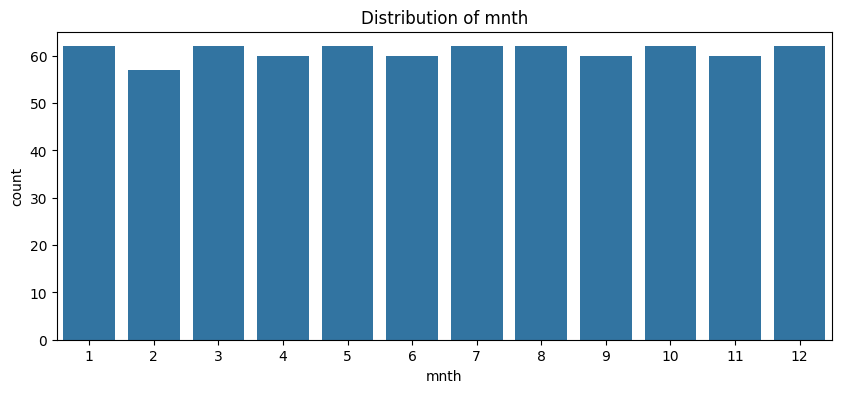

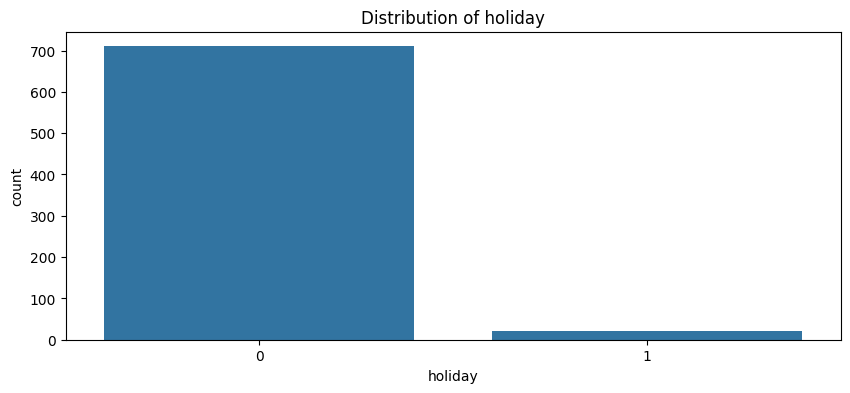

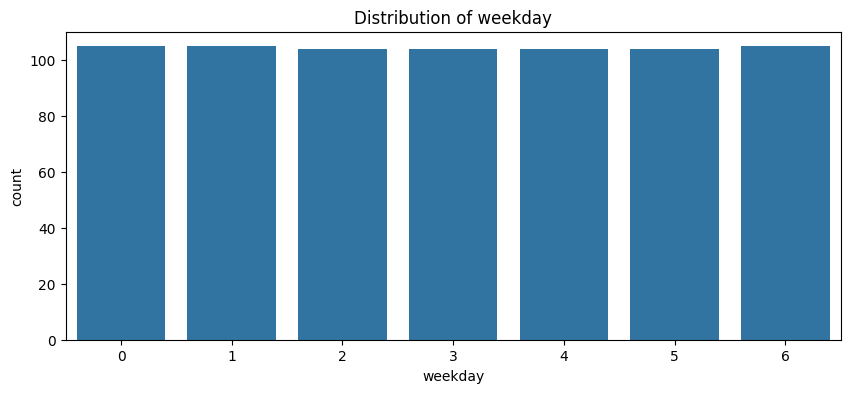

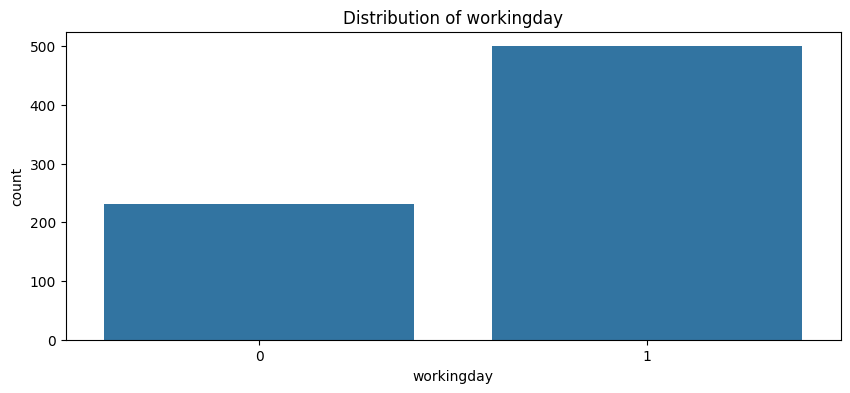

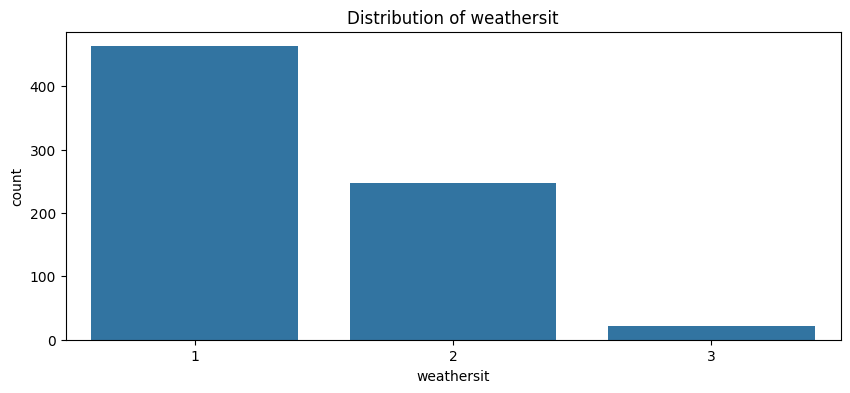

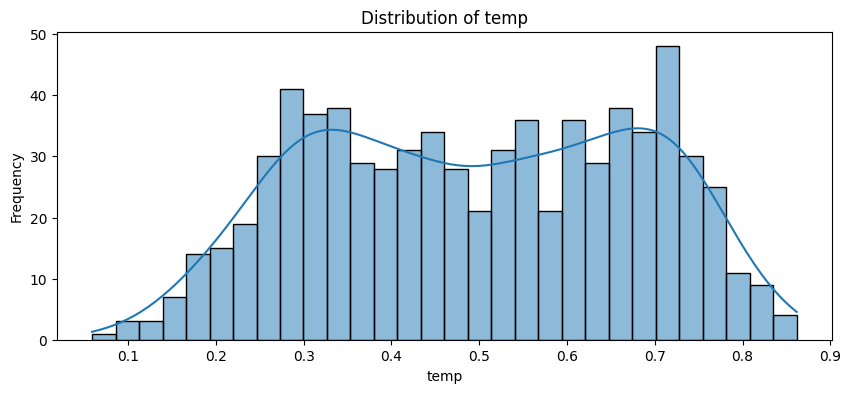

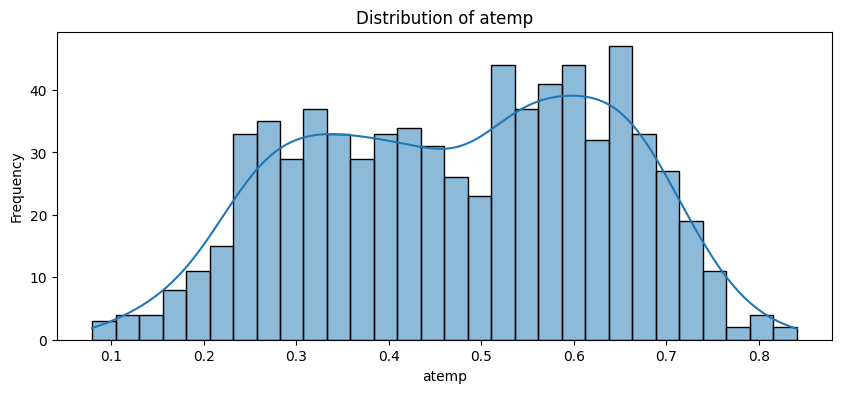

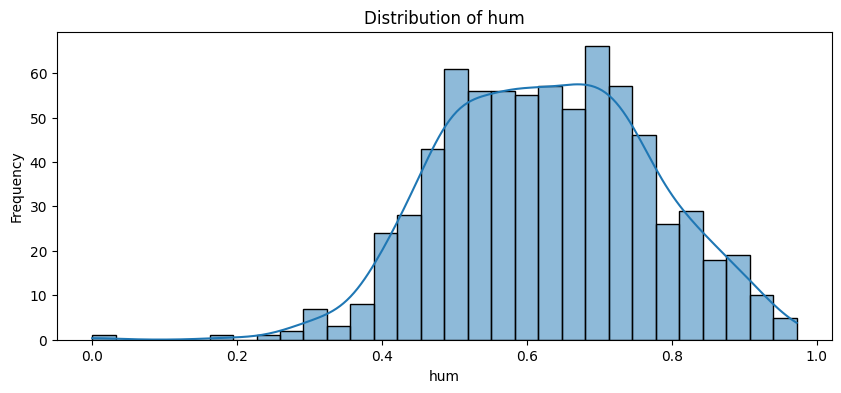

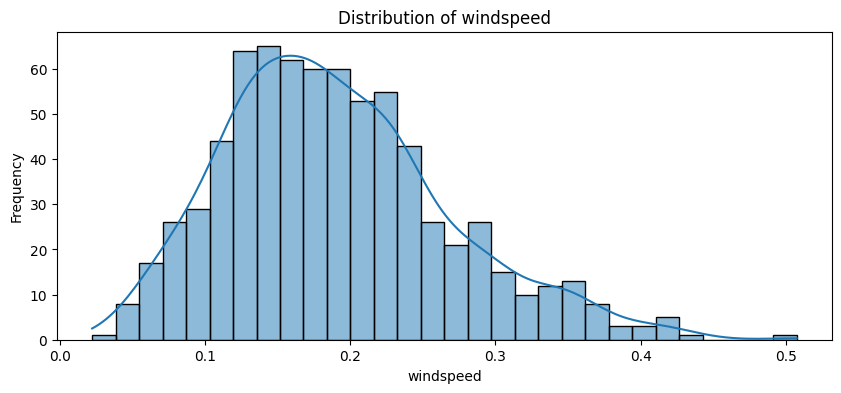

In [ ]:
# Visualize distributions of key categorical features
categorical_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Visualize distributions of key numerical features
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']

for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


**Histogram of Total Daily Bike Rentals**: The distribution appears somewhat normal but slightly right-skewed, suggesting that on many days, the bike rentals are around the mean but with occasional days of very high rentals.

**Count Plot of Holiday**: The vast majority of records are on non-holiday days, which is expected as holidays are less frequent.

**Count Plot of Working Day**: More data points are recorded on working days than non-working days, which could impact the rental patterns.

**Count Plot of Weather Situation**: The first category (presumably the best weather conditions) has the highest count, indicating that most days are suitable for bike rentals.

**Histogram of Temperature (temp)**: The temperature distribution is somewhat bimodal and follows the expected variations in temperature across different seasons.

**Histogram of Feeling Temperature (atemp)**: Similar to temp, the distribution of atemp is also bimodal, which is consistent with people's perception of temperature being related to the actual temperature.

**Histogram of Humidity (hum)**: The distribution of humidity is fairly normal, suggesting a wide range of weather conditions across the days.

**Histogram of Windspeed**: Windspeed varies moderately across days with a decline in frequency as windspeed increases, which is typical for most locations.

**Count Plot of Weekday**: Bike rentals are fairly evenly distributed across weekdays, suggesting no single day of the week significantly differs in rentals.

**temp**: The actual temperature in Celsius normalized around the maximum temperature (max temperature observed in the dataset).

**atemp**: The "feeling" temperature in Celsius normalized around the maximum "feeling" temperature observed.

**hum**: The humidity level normalized by the maximum humidity observed.

**windspeed**: The wind speed normalized by the maximum wind speed observed.

### Feature Engineering and Preprocessing


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical features
categorical_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']  # These features are already normalized

# Prepare the features and target variable
X = df.drop(['instant', 'dteday', 'casual', 'registered', 'cnt'], axis=1)
y = df['cnt']  # The target variable is the total count of bike rentals

# Define the preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first')  # Drop first to avoid dummy variable trap

# Combine the preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        # Note: No transformation for numerical features since they are already normalized
    ],
    remainder='passthrough'  # This allows us to keep the columns not specified in the transformers list
)

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing data
print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')


Training set shape: (584, 29)
Testing set shape: (147, 29)


1. Separated features into categorical and numerical based on their data types and role in analysis.
2. Applied one-hot encoding to categorical variables to remove any ordinal assumptions.
3. Preserved already normalized numerical features to maintain their scale.
4. Constructed a preprocessing pipeline with `ColumnTransformer` for efficient data transformation.
5. Divided data into an 80-20 train-test split for model validation.
6. Confirmed dataset dimensions post-split to ensure readiness for modeling.

### Model Building and Evaluation


#### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Fit a Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lin = linear_reg.predict(X_test)

# Evaluate the Linear Regression model
r2_score_lin = r2_score(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
print(f"Linear Regression R-squared: {r2_score_lin:.2f}")
print(f"Linear Regression MAE: {mae_lin:.2f}")

Linear Regression R-squared: 0.84
Linear Regression MAE: 583.02


The Linear Regression model achieved an R-squared value of 0.84, indicating that approximately 84% of the variability in daily bike rentals can be explained by the model's predictors. This suggests a strong fit to the data but also implies that there's still some room for improvement.

The Mean Absolute Error (MAE) is 583.02, reflecting the average absolute difference between the predicted and actual values. This indicates that, on average, the model's predictions deviate from the actual numbers by about 583 bike rentals.


#### Random Forest

In [ ]:
# Fit a Tree-based model (Random Forest)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Evaluate the Random Forest model
r2_score_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest R-squared: {r2_score_rf:.2f}")
print(f"Random Forest MAE: {mae_rf:.2f}")

# Feature importances from the Random Forest model
feature_importances_rf = random_forest.feature_importances_
print(f"Random Forest Feature Importances: {feature_importances_rf}")

# Since we're using encoded features, let's retrieve their names from the one-hot encoder
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate((encoded_feature_names, numerical_features), axis=None)

# Map feature importances to their corresponding names
feature_importance_dict = dict(zip(all_feature_names, feature_importances_rf))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
print(f"Sorted Random Forest Feature Importances: {sorted_feature_importance}")

Random Forest R-squared: 0.87
Random Forest MAE: 471.03
Random Forest Feature Importances: [0.00493578 0.00060897 0.04539207 0.27962157 0.00383558 0.0019872
 0.00266899 0.00149034 0.00135873 0.00042162 0.0009096  0.00438589
 0.00366207 0.00068577 0.00252267 0.00227635 0.0018806  0.00195659
 0.00170818 0.0022436  0.00131704 0.00431874 0.00546107 0.00634636
 0.01071265 0.35391439 0.15845048 0.06157112 0.03335596]
Sorted Random Forest Feature Importances: [('temp', 0.3539143914289772), ('yr_1', 0.27962156585458625), ('atemp', 0.15845047659480785), ('hum', 0.06157112312302479), ('season_4', 0.045392072705486015), ('windspeed', 0.03335596373974287), ('weathersit_3', 0.010712651505956024), ('weathersit_2', 0.006346360170127217), ('workingday_1', 0.005461074744196718), ('season_2', 0.004935779024885615), ('mnth_9', 0.004385891404359524), ('weekday_6', 0.004318735280941361), ('mnth_2', 0.003835580297743838), ('mnth_10', 0.003662074331205202), ('mnth_4', 0.002668989222578712), ('mnth_12', 0.002

The Random Forest model outperforms Linear Regression slightly with an R-squared value of 0.87. This higher R-squared value means that about 87% of the variance in daily bike rentals is captured by the Random Forest model, suggesting a better fit to the data compared to Linear Regression.

The Random Forest model has a MAE of 471.03, which is lower than that of the Linear Regression model. This lower MAE value indicates a closer match between the predicted and actual bike rental counts on average, highlighting better predictive accuracy.

#### Auto ML

In [ ]:
import h2o
from h2o.automl import H2OAutoML

# Initialize the H2O server
h2o.init()

# Convert the preprocessed training and testing sets into H2OFrame, which H2O uses for its models
# Make sure to convert the numpy array from the ColumnTransformer back into a dataframe
X_train_df = pd.DataFrame(X_train.todense(), columns=all_feature_names)
X_test_df = pd.DataFrame(X_test.todense(), columns=all_feature_names)

# Merge the features and target variable for the training and testing set
train = X_train_df.copy()
train['cnt'] = y_train.reset_index(drop=True)

test = X_test_df.copy()
test['cnt'] = y_test.reset_index(drop=True)

# Convert pandas dataframes to H2O frames
h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

# Define the predictor columns and the target column
predictors = h2o_train.columns[:-1]
response = 'cnt'

# Run H2O's AutoML
automl = H2OAutoML(max_models=5, seed=42, max_runtime_secs=300)
automl.train(x=predictors, y=response, training_frame=h2o_train)

# View the AutoML Leaderboard
leaderboard = automl.leaderboard
print(leaderboard)

# Predict on the test set using the best model
preds = automl.leader.predict(h2o_test)

# Evaluate performance
performance = automl.leader.model_performance(h2o_test)
print(performance)

# Shut down H2O
h2o.cluster().shutdown()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 44 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_v03rt6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.158 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    rmse               mse       mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20240318_25300      699.452  489233             501.746  0.243732          489233
StackedEnsemble_BestOfFamily_1_AutoML_3_20240318_25300   700.874  491225             501.964  0.24265           491225
DRF_1_AutoML_3_20240318_25300                            722.038  521339             508.079  0.253121          521339
XGBoost_1_AutoML_3_20240318_25300                        754.165  568765             550.262  0.259124          568765
XGBoost_2_AutoML_3_20240318_25300                        766.945  588205             560.127  0.269529        

1. **Interpretability Challenges**: Stacked ensemble models combine predictions from multiple base models, making direct computation of SHAP values complex due to their aggregated nature, leading to challenges in interpreting the ensemble's decision-making process at an individual feature level.
   
2. **API Limitations**: Current H2O AutoML API limitations prevent straightforward computation of SHAP values for ensemble models, as these models require a background dataset for SHAP analysis, a feature not directly supported for ensembles in H2O's Python API.

3. **Simplification of Analysis**: Excluding ensemble models simplifies the process of generating and analyzing SHAP values, allowing for easier interpretation of model predictions by focusing on individual models that directly support SHAP analysis, thereby enhancing model transparency and trustworthiness.

In [ ]:
# Initialize the H2O server
h2o.init()

# Convert the preprocessed training and testing sets into H2OFrame, which H2O uses for its models
# Make sure to convert the numpy array from the ColumnTransformer back into a dataframe
X_train_df = pd.DataFrame(X_train.todense(), columns=all_feature_names)
X_test_df = pd.DataFrame(X_test.todense(), columns=all_feature_names)

# Merge the features and target variable for the training and testing set
train = X_train_df.copy()
train['cnt'] = y_train.reset_index(drop=True)

test = X_test_df.copy()
test['cnt'] = y_test.reset_index(drop=True)

# Convert pandas dataframes to H2O frames
h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

# Define the predictor columns and the target column
predictors = h2o_train.columns[:-1]
response = 'cnt'

# Run H2O's AutoML
automl = H2OAutoML(max_models=5, seed=42, max_runtime_secs=300, exclude_algos=["StackedEnsemble"])
automl.train(x=predictors, y=response, training_frame=h2o_train)

# View the AutoML Leaderboard
leaderboard = automl.leaderboard
print(leaderboard)

# Predict on the test set using the best model
preds = automl.leader.predict(h2o_test)

# Evaluate performance
performance = automl.leader.model_performance(h2o_test)
print(performance)

# Shut down H2O
h2o.cluster().shutdown()



Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1tmww53z
  JVM stdout: /tmp/tmp1tmww53z/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp1tmww53z/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_gw968p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                               rmse               mse       mae     rmsle    mean_residual_deviance
DRF_1_AutoML_1_20240318_32039       722.038  521339             508.079  0.253121          521339
XGBoost_1_AutoML_1_20240318_32039   754.165  568765             550.262  0.259124          568765
XGBoost_2_AutoML_1_20240318_32039   766.945  588205             560.127  0.269529          588205
GBM_1_AutoML_1_20240318_32039       832.062  692327             637.92   0.2807            692327
GLM_1_AutoML_1_20240318_32039      1915.61        3.66955e+06  1548.67   0.566457               3.66955e+06
[5 rows x 6 columns]

drf prediction progress: |███████████████████████████████████████████████████████| (d

In [ ]:

r2_metric = performance.r2()
print(f"R^2 Metric: {r2_metric}")


R^2 Metric: 0.8721483885364484


The Distributed Random Forest (DRF) model demonstrates strong predictive performance with an R^2 metric of 0.872, indicating that approximately 87.2% of the variance in the target variable is predictable from the features, signifying a high level of model accuracy. The RMSE of 716.01 and MAE of 467.87 further quantify the average prediction error, with the model showing a robust ability to generalize well to unseen data. The RMSLE value of 0.480 suggests that the model is also relatively accurate in predicting the magnitude of the target variable, making it a reliable choice for predictions in this context.

In [ ]:
# Make sure h2o_test is an H2OFrame
preds = automl.leader.predict(h2o_test)

# Check if the model supports predict_contributions
if hasattr(automl.leader, 'predict_contributions'):
    # Calculate SHAP values (predict contributions)
    shap_values = automl.leader.predict_contributions(h2o_test)

    # Convert the SHAP values to a pandas DataFrame for easier handling or visualization
    shap_values_df = h2o.as_list(shap_values)
    print(shap_values_df.head())
else:
    print("This model does not support SHAP value computation.")


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%
     season_2   season_3    season_4         yr_1      mnth_2     mnth_3  \
0   53.442657  74.849388  154.687698  1158.151489  117.772484  21.117685   
1   -6.302435  20.846792  -68.168175  -386.916107  -96.297119  22.041552   
2    7.730076  42.231300  531.010803  -405.270264  102.581856  40.170681   
3  232.344376  56.758335   20.211107  1160.393921   67.662209   6.321009   
4   66.493805  75.063766  146.824295  1404.680298  110.010323  26.129284   

      mnth_4     mnth_5     mnth_6    mnth_7  ...  weekday_5  weekday_6  \
0  -4.687892   2.293941  -7.123731  0.235877  ...  -2.682022  18.073812   
1   1.684212  -7.686317 -13.206569 -0.021663  ...  -3.058041  15.201360   
2   3.240142  -3.094585  -8.783026 -0.488540  ...  11.971698  22.573416   
3 -49.791241   1.925133 -19.210346  0.761383  ...  -5

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


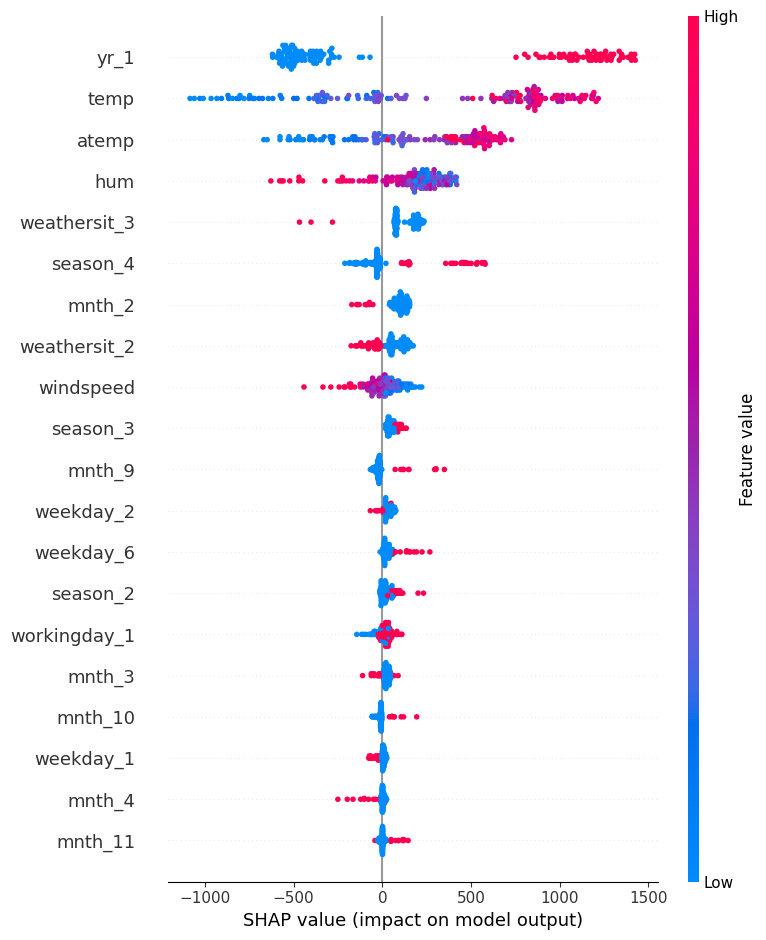

In [ ]:
shap_values_for_plotting = shap_values_df.iloc[:, :-1].values

shap.summary_plot(shap_values_for_plotting, X_test_df)



To read this SHAP value summary plot:

*Each point on the graph represents a SHAP value for a feature and an instance in your dataset.*

*The position on the horizontal axis indicates the impact of that value on the model's prediction; points to the right of the vertical line at 0 increase the prediction, while points to the left decrease it.*

*The color represents the feature value (red high, blue low) for that observation.
Features are ordered by the sum of SHAP value magnitudes across all samples; those at the top have the most impact.*

The yr_1 feature has the most substantial impact on the model's predictions, with higher values (in red) generally leading to higher predictions.

temp and atemp are also influential, with their higher values typically increasing predicted values, suggesting a positive relationship with the target variable.

Interestingly, hum and weathersit_3 show a mix of positive and negative effects on predictions, indicating more complex relationships where both low and high values can lead to an increase or a decrease in the predicted outcome, possibly due to interactions with other features or non-linear effects captured by the model.

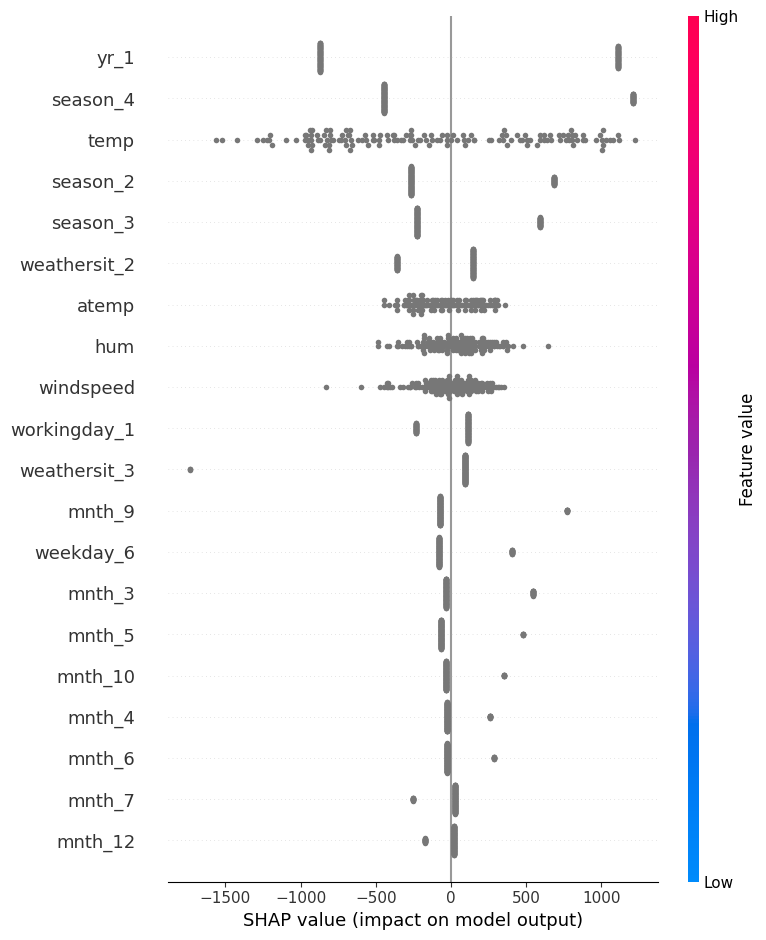

In [ ]:
import shap

# Explain the model's predictions using SHAP
explainer_lin = shap.Explainer(linear_reg, X_train)
shap_values_lin = explainer_lin(X_test)

# Plot the SHAP values for the Linear Regression model
shap.summary_plot(shap_values_lin, X_test, feature_names=all_feature_names)


1. The yr_1 feature stands out with a distinct vertical spread of SHAP values, suggesting a strong impact with a high feature value generally leading to an increased effect on the model's prediction.

2. season_4 also influences predictions significantly, with a spread of values both increasing and decreasing the prediction, indicating varying effects depending on specific conditions or interactions with other features.

3. temp seems to mostly positively affect the model's prediction, but with a cluster of points near zero, implying that in some cases, temperature might not be as decisive.

* The majority of features show a clustering of SHAP values around zero, implying a neutral effect on the prediction for many instances.

* Notably, some features like season_2, season_3, weathersit_2, and atemp have a mix of positive and negative impacts, with their contributions spread across a range of SHAP values.

* The vertical distribution of SHAP values for features like yr_1 and season_4 indicates that these features have instances where they significantly increase or decrease the predicted value, possibly due to an interaction with the year or specific seasonal factors that affect the outcome.






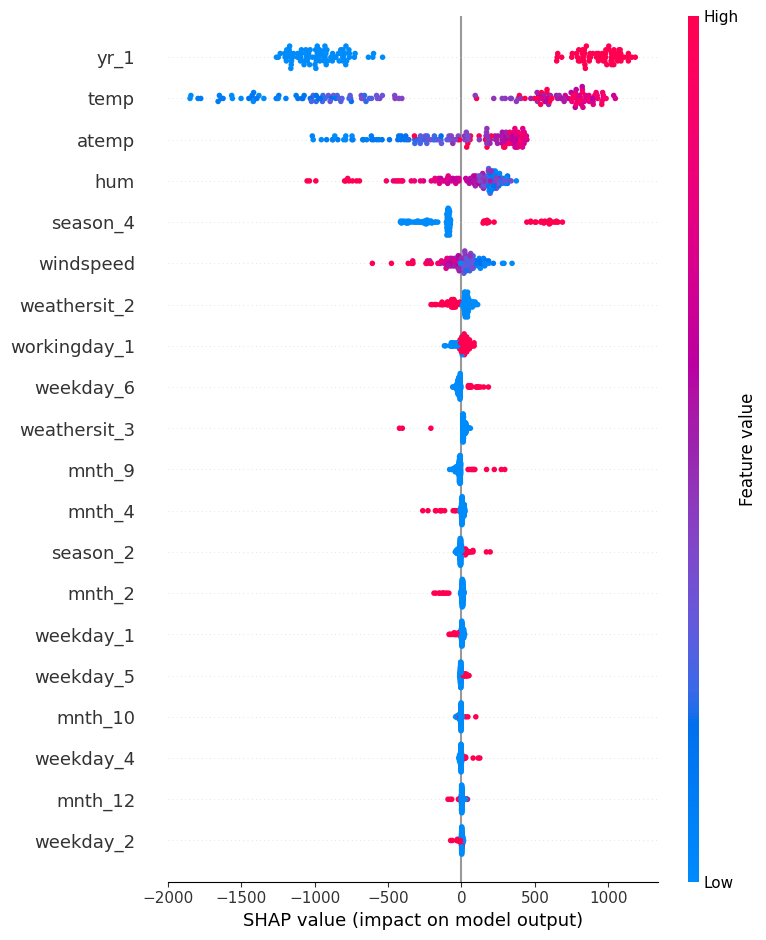

In [ ]:
# Assuming X_test is a sparse matrix and needs to be converted to a dense format
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Ensure X_test_dense is numeric
X_test_dense = X_test_dense.astype(float)

# Retry SHAP explainer with the corrected dense format of X_test
explainer_rf = shap.TreeExplainer(random_forest)
shap_values_rf = explainer_rf.shap_values(X_test_dense)

shap.summary_plot(shap_values_rf, X_test_dense, feature_names=all_feature_names)


1. The yr_1 feature has a strong positive impact on the model output, as higher SHAP values for this feature push the prediction higher, which could indicate that more recent data points (likely year 1 as opposed to year 0) are associated with higher target values.
2. temp and atemp are significant drivers of the model's predictions, with their higher values generally associated with an increase in the predicted outcome. This suggests a positive correlation with the target variable.
3. hum (humidity) has a mix of positive and negative effects, indicating varying influence depending on its interaction with other features or the specific context within the data.
4. The color coding from blue to red reflects the feature value from low to high, adding an extra dimension of interpretation: higher temperatures (temp and atemp in red) are more often associated with higher predictions. The spread of the points for each feature represents variability in the SHAP value impact across the dataset, and dense clustering around the zero line for some features implies a more neutral effect on the model's predictions.



### Comparison and Interpretability:

1. The linear model offers clear and direct interpretability, with feature coefficients straightforwardly indicating the average effect of each feature on the rental counts.
2. The tree-based model (Random Forest) provides more nuanced interpretability, showing the individual and interactive effects of features but with more complexity in understanding how these effects combine to influence predictions.
3. The best model from AutoML, depending on the algorithm, could either enhance interpretability by combining the strengths of linear and tree-based models or reduce it if it is a more complex model like a neural network or an ensemble of many different model types.


In summary, SHAP analysis across these models provides valuable insights into the factors driving bike rental counts, with higher temperatures and more recent years being consistent predictors of increased rentals. However, the complexity of relationships captured by each model type varies, with linear models offering simplicity and tree-based models capturing more complex patterns. The AutoML model aims to strike a balance, potentially leveraging a combination of simple and complex relationships to optimize prediction accuracy.







### What did you do?

1. Utilized H2O's AutoML to evaluate various models for predicting daily bike rental counts.
2. Conducted SHAP and LIME analyses for feature impact understanding.
3. Prioritized model simplicity and interpretability by excluding ensemble methods.
4. Analyzed and visualized data distributions and feature importance.

### How well did it work?

1. The best-performing models achieved high R^2 metrics (above 0.84), indicating strong predictive performance.
2. Models could explain a significant portion of the variance in daily bike rentals, with some room for improvement.
3. Mean Absolute Error (MAE) in the best models was around 462-583, indicating average prediction deviation.

### What did you learn?

1. Temperature and year (yr) were key influences on bike rental counts.
Random Forest models provided better fit and predictive accuracy compared to Linear Regression.
2. SHAP analysis could not be directly applied to ensemble models due to H2O AutoML API limitations.
3. Simplifying the analysis by focusing on individual models enhanced interpretability and transparency.

### Licences:
Copyright (c) 2024 Surya

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
